import torch
from torchvision.models import resnet50

from vit_pytorch.distill import DistillableViT, DistillWrapper

teacher = resnet50(pretrained = True)

v = DistillableViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

distiller = DistillWrapper(
    student = v,
    teacher = teacher,
    temperature = 3,           # temperature of distillation
    alpha = 0.5,               # trade between main loss and distillation loss
    hard = False               # whether to use soft or hard distillation
)

img = torch.randn(2, 3, 256, 256)
labels = torch.randint(0, 1000, (2,))

loss = distiller(img, labels)
loss.backward()
# Cancer🔬 Classification: Baseline with ⚡`lightning`

**It is continuation of EDA: https://www.kaggle.com/code/jirkaborovec/cancer-subtype-explore-data-images**

In [1]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATASET_FOLDER = "/kaggle/input/UBC-OCEAN/"
DATASET_IMAGES = "/kaggle/input/cancer-subtype-eda-load-wsi-prune-bg/train_thumbnails/"

## Checkout some labels

In [2]:
df_train = pd.read_csv(os.path.join(DATASET_FOLDER, "train.csv"))
# labels = list(df_train["label"].unique())
print(f"Dataset/train size: {len(df_train)}")
display(df_train.head())

Dataset/train size: 538


,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False


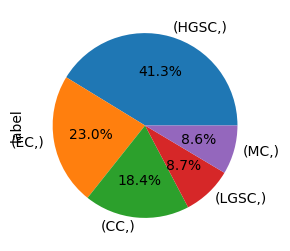

In [3]:
_= df_train[["label"]].value_counts().plot.pie(autopct='%1.1f%%', ylabel="label", figsize=(3,3))

### Show some samples 🖼️ per class

Note that not all images has thumbnails

In [4]:
df_train["path_thumbnail"] = df_train['image_id'].apply(lambda id: f"{id}_thumbnail.png")
df_train["thumbnail_exists"] = df_train['path_thumbnail'].apply(
    lambda pth: os.path.isfile(os.path.join(DATASET_IMAGES, pth)))
display(df_train.head())
df_train = df_train[df_train["thumbnail_exists"] == True]
print(f"size: {len(df_train)}")

,image_id,label,image_width,image_height,is_tma,path_thumbnail,thumbnail_exists
0,4,HGSC,23785,20008,False,4_thumbnail.png,True
1,66,LGSC,48871,48195,False,66_thumbnail.png,True
2,91,HGSC,3388,3388,True,91_thumbnail.png,True
3,281,LGSC,42309,15545,False,281_thumbnail.png,True
4,286,EC,37204,30020,False,286_thumbnail.png,True


size: 538


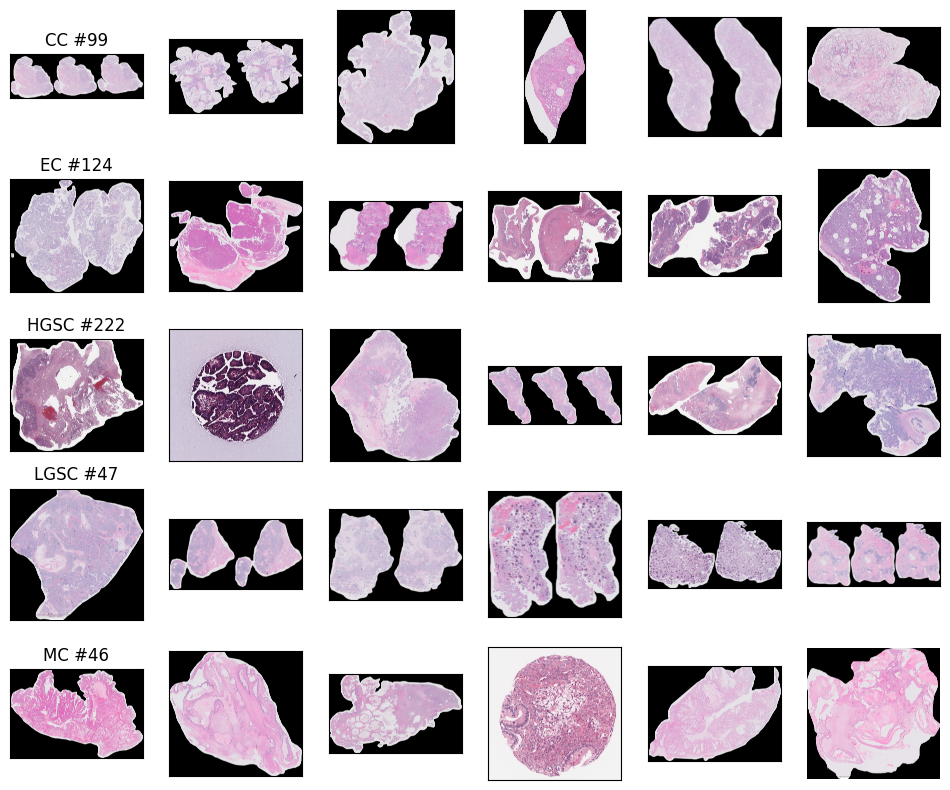

In [5]:
import matplotlib.pyplot as plt

nb_samples = 6
n, m = len(np.unique(df_train['label'])), nb_samples,
fig, axarr = plt.subplots(nrows=n, ncols=m, figsize=(m * 2, n * 2))
for ilb, (lb, df_) in enumerate(df_train.groupby('label')):
    img_ids = list(df_['image_id'])
    for i in range(m):
        img_path = os.path.join(DATASET_IMAGES, f"{img_ids[i]}_thumbnail.png")
        img = plt.imread(img_path)
        axarr[ilb, i].imshow(img)
        if i == 0:
            axarr[ilb, i].set_title(f"{lb} #{len(df_)}")
        axarr[ilb, i].set_xticks([])
        axarr[ilb, i].set_yticks([])
_= plt.axis('off')

## Data pre-processing

### Sacling down images

We could not fit this huge image size to any NEt so just as offline process lets downscale it to about 1024x1024

In [6]:
def prune_image_rows_cols(img, thr=0.001):
    # delete empty columns
    for l in reversed(range(img.shape[1])):
        if (np.sum(img[:, l]) / float(img.shape[0])) < thr:
            img = np.delete(img, l, 1)
    # delete empty rows
    for l in reversed(range(img.shape[0])):
        if (np.sum(img[l, :]) / float(img.shape[1])) < thr:
            img = np.delete(img, l, 0)
    return img

In [7]:
def prune_scale_image(img_path: str, out_dir: str, size: int = 1024) -> None:
    img = np.array(Image.open(img_path))
    img = prune_image_rows_cols(img)
    mask = np.sum(img[..., :3], axis=2) == 0
    img[mask, :] = 255
    img = Image.fromarray(img)
    img.thumbnail((size, size))
    img.save(os.path.join(out_dir, os.path.basename(img_path)))

In [8]:
import glob
from PIL import Image
from tqdm.auto import tqdm
from joblib import Parallel, delayed

! mkdir -p train_thumbnails
! rm -f train_thumbnails/*.png

ls = glob.glob(os.path.join(DATASET_IMAGES, '*.png'))
print(f"found images: {len(ls)}")

# for p_img in tqdm(ls):
#     prune_scale_image(p_img, "./train_thumbnails")
    
_= Parallel(n_jobs=4)(
    delayed(prune_scale_image)(p_img, "./train_thumbnails") for p_img in tqdm(ls)
)
ls = glob.glob(os.path.join("./train_thumbnails", '*.png'))
print(f"found images: {len(ls)}")

found images: 538


  0%|          | 0/538 [00:00<?, ?it/s]

found images: 538


### Color 🦩 normalizations

In [9]:
def _color_means(img_path):
    img = np.array(Image.open(img_path))
    if np.max(img) > 1.5:
        img = img / 255.0
    clr_mean = {i: np.mean(img[..., i]) for i in range(3)}
    clr_std = {i: np.std(img[..., i]) for i in range(3)}
    return clr_mean, clr_std

# os.path.join(DATASET_SMALL_FOLDER, "train_images")
ls_images = glob.glob(os.path.join("./train_thumbnails", "*.png"))
clr_mean_std = Parallel(n_jobs=os.cpu_count())(delayed(_color_means)(fn) for fn in tqdm(ls_images))

  0%|          | 0/538 [00:00<?, ?it/s]

In [10]:
img_color_mean = pd.DataFrame([c[0] for c in clr_mean_std]).describe()
display(img_color_mean.T)
img_color_std = pd.DataFrame([c[1] for c in clr_mean_std]).describe()
display(img_color_std.T)

img_color_mean = list(img_color_mean.T["mean"])
img_color_std = list(img_color_std.T["mean"])
print(f"{img_color_mean=}\n{img_color_std=}")

,count,mean,std,min,25%,50%,75%,max
0,538.0,0.889442,0.036619,0.684325,0.868408,0.892795,0.912935,0.973248
1,538.0,0.820875,0.050274,0.584903,0.794647,0.827446,0.855047,0.968550
2,538.0,0.886402,0.033381,0.699953,0.874796,0.892046,0.906543,0.975766


,count,mean,std,min,25%,50%,75%,max
0,538.0,0.101064,0.026599,0.051235,0.082776,0.097651,0.116948,0.233117
1,538.0,0.156377,0.035347,0.079651,0.132373,0.148813,0.171572,0.283007
2,538.0,0.098927,0.024028,0.058827,0.085030,0.093158,0.103256,0.242349


img_color_mean=[0.8894420586142374, 0.8208752169441305, 0.886401614138935]
img_color_std=[0.10106393015358608, 0.15637655015581306, 0.09892687853183288]


## Dataset & DataModule

Creating standard PyTorch dataset to define how the data shall be loaded and set representations. We define the sample pair as:
- RGB image
- one-hot lable encding

A DataModule standardizes the training, val, test splits, data preparation and transforms. The main advantage is consistent data splits, data preparation and transforms across models.

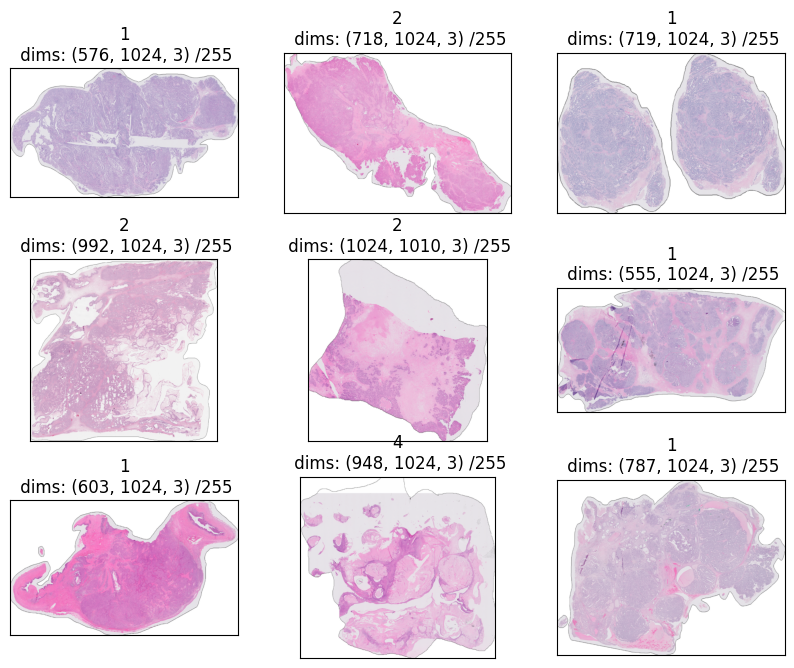

In [11]:
import torch
from torch.utils.data import Dataset

class CancerThumbnailDataset(Dataset):
    split: float = 0.90

    def __init__(
        self,
        df_data,
        path_img_dir: str =  'train_thumbnails',
        transforms = None,
        mode: str = 'train',
        labels_lut = None
    ):
        # 数据集的初始化方法
        self.path_img_dir = path_img_dir  # 图像文件的路径
        self.transforms = transforms  # 数据变换
        self.mode = mode  # 数据集模式（训练或验证）

        self.data = df_data  # 数据集的DataFrame
        self.labels_unique = sorted(self.data["label"].unique())  # 唯一标签列表
        self.labels_lut = labels_lut or {lb: i for i, lb in enumerate(self.labels_unique)}  # 标签字典
        # 随机打乱数据
        self.data = self.data.sample(frac=1, random_state=42).reset_index(drop=True)

        # 划分数据集
        assert 0.0 <= self.split <= 1.0
        frac = int(self.split * len(self.data))
        self.data = self.data[:frac] if mode == 'train' else self.data[frac:]
        self.img_names = [f"{id}_thumbnail.png" for id in self.data["image_id"]]
        self.labels = list(self.data['label'])  # 数据集的标签列表

    @property
    def num_classes(self) -> int:
        # 返回数据集中的类别数
        return len(self.labels_lut)

    def to_one_hot(self, label: str) -> int:
        # 将标签转换为索引
        return self.labels_lut[label]

    def __getitem__(self, idx: int) -> tuple:
        # 根据索引获取图像和标签
        img_path = os.path.join(self.path_img_dir, self.img_names[idx])
        assert os.path.isfile(img_path), f"missing: {img_path}"
        img = plt.imread(img_path)[..., :3]  # 读取图像
        if np.max(img) < 1.5:
            img = np.clip(img * 255, 0, 255).astype(np.uint8)
        labels = self.to_one_hot(self.labels[idx])  # 转换标签为独热编码

        # 数据增强
        if self.transforms:
            img = self.transforms(Image.fromarray(img))

        return img, torch.tensor(labels).to(int)

    def __len__(self) -> int:
        # 返回数据集的长度
        return len(self.data)

# ==============================
# ==============================

# 创建数据集实例
dataset = CancerThumbnailDataset(df_train)

# 可视化数据集的前9个样本
fig = plt.figure(figsize=(10, 8))
for i in range(9):
    img, lb = dataset[i]
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(f"{lb}\n dims: {img.shape} /{np.max(img)}")


### Let us define some standard image augmentaion procedures and color normalizations...

In [12]:
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode

TRAIN_TRANSFORM = T.Compose([
    T.RandomRotation(45, fill=255),
    T.RandomCrop(512, pad_if_needed=True, padding_mode="reflect"),
    #T.RandomResizedCrop(512, interpolation=InterpolationMode.BICUBIC, antialias=True),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    #T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    T.Normalize(img_color_mean, img_color_std),  # custom
])

VALID_TRANSFORM = T.Compose([
    T.CenterCrop(512),
    T.ToTensor(),
    #T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    T.Normalize(img_color_mean, img_color_std),  # custom
])

### The DataModule include creating training and validation dataset with given split and feading it to particular data loaders...

training dataset: 484
validation dataset: 54
5
batch labels: 9
image size: torch.Size([3, 512, 512])


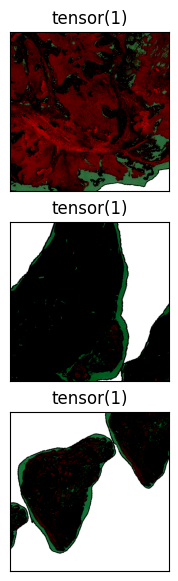

In [13]:
import multiprocessing as mproc
import pytorch_lightning as pl
from torch.utils.data import DataLoader

# 定义一个PyTorch Lightning数据模块
class CancerSubtypeDM(pl.LightningDataModule):

    def __init__(
        self,
        df_data,
        path_img_dir: str = 'train_thumbnails',
        batch_size: int = 32,
        num_workers: int = None,
        train_transforms = TRAIN_TRANSFORM,
        valid_transforms = VALID_TRANSFORM
    ):
        super().__init__()
        self.df_data = df_data
        self.path_img_dir = path_img_dir
        self.batch_size = batch_size
        # 确定使用的工作进程数（默认为CPU核心数）
        self.num_workers = num_workers or mproc.cpu_count()
        self.train_dataset = None
        self.valid_dataset = None
        self.train_transforms = train_transforms
        self.valid_transforms = valid_transforms

    # 准备数据的方法，可以留空
    def prepare_data(self):
        pass

    # 返回类别数
    @property
    def num_classes(self) -> int:
        assert self.train_dataset and self.valid_dataset
        return len(set(self.train_dataset.labels_unique + self.valid_dataset.labels_unique))

    # 设置训练和验证数据集
    def setup(self, stage=None):
        self.train_dataset = CancerThumbnailDataset(
            self.df_data, self.path_img_dir, mode='train', transforms=self.train_transforms)
        print(f"training dataset: {len(self.train_dataset)}")
        self.valid_dataset = CancerThumbnailDataset(
            self.df_data, self.path_img_dir, mode='valid', transforms=self.valid_transforms,
            labels_lut=self.train_dataset.labels_lut)
        print(f"validation dataset: {len(self.valid_dataset)}")

    # 创建训练数据加载器
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )

    # 创建验证数据加载器
    def val_dataloader(self):
        return DataLoader(
            self.valid_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

    # 创建测试数据加载器
    def test_dataloader(self):
        pass

# 创建数据模块对象
dm = CancerSubtypeDM(df_train, batch_size=8)
# 设置数据模块
dm.setup()
# 打印类别数
print(dm.num_classes)

# 快速查看数据集中的一批图像
fig = plt.figure(figsize=(3, 7))
for imgs, lbs in dm.train_dataloader():
    print(f'batch labels: {torch.sum(lbs, axis=0)}')
    print(f'image size: {imgs[0].shape}')
    for i in range(3):
        ax = fig.add_subplot(3, 1, i + 1, xticks=[], yticks=[])
        ax.imshow(np.rollaxis(imgs[i].numpy(), 0, 3))
        ax.set_title(lbs[i])
    break


## ViT Model

We start with some standard ViT models.
Then we define Ligthning module including training and validation step and configure optimizer/schedular.

In [ ]:
!pip install -q /kaggle/input/vit-pytorch/vit_pytorch-1.6.4-py3-none-any.whl

In [ ]:
from __future__ import print_function

from itertools import chain
import random

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm

### Training settings

In [ ]:
batch_size = 16
epochs = 60
lr = 0.01
# gamma = 0.7

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Visual Transformer

In [ ]:
from vit_pytorch.vit_for_small_dataset import ViT

model = ViT(
    image_size = 512,
    patch_size = 16,
    num_classes = 5,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

## Training

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
# scheduler
# scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [ ]:
# 初始化记录指标的空列表
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# 循环训练
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(dm.train_dataloader()):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(dm.train_dataloader())
        epoch_loss += loss / len(dm.train_dataloader())

    # 获取当前学习率
    current_lr = optimizer.param_groups[0]['lr']
    
    # 记录训练集的损失和准确率
    train_losses.append(epoch_loss.item())
    train_accuracies.append(epoch_accuracy.item())

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in dm.val_dataloader():
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label.long())

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(dm.val_dataloader())
            epoch_val_loss += val_loss / len(dm.val_dataloader())
            
        # 记录验证集的损失和准确率
        val_losses.append(epoch_val_loss.item())
        val_accuracies.append(epoch_val_accuracy.item())
       
    # 更新学习率
    scheduler.step(epoch_val_loss)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} - lr: {current_lr}\n"
    )

Quick visualization of the training process...

In [ ]:
# 绘制指标关系图
import matplotlib.pyplot as plt

# 绘制训练集和验证集的损失
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.title('Training and Validation Loss')
plt.legend()

# 绘制训练集和验证集的准确率
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='train accuracy')
plt.plot(val_accuracies, label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

Save the model!

In [ ]:
torch.save(model.state_dict(), './trained-vit.pt')

Inference coming in https://www.kaggle.com/code/jirkaborovec/cancer-subtype-lightning-torch-inference

In [ ]:
import torch
from PIL import Image
from torch.utils.data import Dataset

class TilesFolderDataset(Dataset):
    def __init__(
        self,
        folder_tiles: list,  # 将参数名修改为 folder_tiles，表示这是包含图像文件路径的列表
        image_ext: str = '.png',
        transforms=None
    ):
        self.transforms = transforms
        self.imgs = folder_tiles  # 直接使用 folder_tiles，因为它已经是图像文件的路径列表

    def __getitem__(self, idx: int) -> tuple:
        img_path = self.imgs[idx]
        
        # 断言图像文件存在
        assert os.path.isfile(img_path), f"Missing file: {img_path}"
        
        # 读取图像并去除 alpha 通道
        img = np.array(Image.open(img_path))[..., :3]
        
        # 过滤背景
        mask = np.sum(img, axis=2) == 0
        img[mask, :] = 255
        
        # 如果图像的最大值小于1.5，则将其缩放到0-255的范围
        if np.max(img) < 1.5:
            img = np.clip(img * 255, 0, 255).astype(np.uint8)
        
        # 数据增强
        if self.transforms:
            img = self.transforms(Image.fromarray(img))
        
        return img

    def __len__(self) -> int:
        return len(self.imgs)


In [ ]:
# 从 CSV 文件中读取测试数据集
df_test = pd.read_csv(os.path.join(DATASET_FOLDER, "test.csv"))

# 为每个测试样本设置默认标签 'HGSC'
df_test['label'] = ['HGSC'] * len(df_test)

# 打印测试数据集的大小（行数）
print(f"Dataset/test size: {len(df_test)}")

# 显示测试数据集的前几行，以便查看数据结构和内容
display(df_test.head())


In [ ]:
!cat /kaggle/input/UBC-OCEAN/sample_submission.csv

In [ ]:
!ls /kaggle/input/pyvips-python-and-deb-package-gpu
# intall the deb packages
!yes | dpkg -i --force-depends /kaggle/input/pyvips-python-and-deb-package-gpu/linux_packages/archives/*.deb
# install the python wrapper
!pip install pyvips -f /kaggle/input/pyvips-python-and-deb-package-gpu/python_packages/ --no-index

In [ ]:
import pyvips
import random

DATASET_FOLDER = "/kaggle/input/UBC-OCEAN/"
IMAGES_FOLDER = "/kaggle/working/test_tiles"

In [ ]:
# 读取训练数据集的 CSV 文件，文件路径由 DATASET_FOLDER 和 "train.csv" 构成
df_train = pd.read_csv(os.path.join(DATASET_FOLDER, "train.csv"))

# 获取训练数据集中 "label" 列的唯一值，并按字母顺序排序
labels = sorted(df_train["label"].unique())

# 输出所有标签的唯一值列表
print(f"{labels=}")


In [ ]:
def extract_image_tiles(
    p_img,           # 输入图像的路径
    folder,          # 存储提取的图像块的文件夹路径
    size: int = 2048,  # 每个图像块的大小
    scale: float = 0.5,  # 图像块的缩放比例
    drop_thr: float = 0.6,  # 阈值，用于判断是否丢弃几乎为空的图像块
    white_thr: int = 240,  # 白色的阈值，用于判断是否为空白图像块
    max_samples: int = 50  # 最大提取的图像块数量
) -> list:
    # 从文件路径中提取图像的名称和扩展名
    name, _ = os.path.splitext(os.path.basename(p_img))
    
    # 使用 pyvips 库加载图像
    im = pyvips.Image.new_from_file(p_img)
    
    # 设置图像块的宽度和高度
    w = h = size
    
    # 生成图像块的索引
    idxs = [(y, y + h, x, x + w) for y in range(0, im.height, h) for x in range(0, im.width, w)]
    
    # 对索引进行随机子采样
    max_samples = max_samples if isinstance(max_samples, int) else int(len(idxs) * max_samples)
    random.shuffle(idxs)
    
    # 存储提取的图像块文件路径的列表
    files = []
    
    # 确保文件夹存在或创建文件夹
    os.makedirs(folder, exist_ok=True)
    
    for y, y_, x, x_ in idxs:
        # 使用 pyvips 库裁剪图像块
        tile = im.crop(x, y, min(w, im.width - x), min(h, im.height - y)).numpy()[..., :3]
        
        # 处理非标准大小的图像块
        if tile.shape[:2] != (h, w):
            tile_ = tile
            tile_size = (h, w) if tile.ndim == 2 else (h, w, tile.shape[2])
            tile = np.zeros(tile_size, dtype=tile.dtype)
            tile[:tile_.shape[0], :tile_.shape[1], ...] = tile_
        
        # 处理全黑的图像块
        black_bg = np.sum(tile, axis=2) == 0
        tile[black_bg, :] = 255
        
        # 处理白色背景的图像块
        mask_bg = np.mean(tile, axis=2) > white_thr
        if np.sum(mask_bg) >= (np.prod(mask_bg.shape) * drop_thr):
            # 如果图像块几乎为空，跳过
            continue
        
        # 生成图像块文件的路径
        p_img_path = os.path.join(folder, f"{int(x_ / w)}-{int(y_ / h)}.png")
        
        # 将图像块保存为文件
        new_size = int(size * scale), int(size * scale)
        Image.fromarray(tile).resize(new_size, Image.LANCZOS).save(p_img_path)
        
        # 将文件路径添加到列表中
        files.append(p_img_path)
        
        # 设置计数器检查，以便一些空的图像块可能被提前跳过
        if len(files) >= max_samples:
            break
    
    # 返回提取的图像块文件路径列表
    return files


In [ ]:
import shutil
from torch.utils.data import DataLoader

# 将模型设置为评估模式
model.eval()
# 将模型移动到 GPU 上
model = model.cuda()

# 初始化一个空的列表 submission 用于存储最终的提交结果
submission = []

# 遍历测试数据集中的每一行
for _, row in df_test.iterrows():
    # 复制当前行
    row = dict(row)
    
    # 准备数据 - 切割并加载图像块
    folder_tiles = extract_image_tiles(
        os.path.join(DATASET_FOLDER, "test_images", f"{str(row['image_id'])}.png"),
        IMAGES_FOLDER, size=2048, scale=0.25)
    
    # 创建数据集
    dataset = TilesFolderDataset(folder_tiles, transforms=VALID_TRANSFORM)
    
    # 如果数据集为空，则输出一条消息并将当前行添加到 submission 列表中，继续下一次循环
    if not len(dataset):
        print (f"seem no tiles were cut for `{folder_tiles}`")
        submission.append(row)
        continue
    
    # 创建 DataLoader 用于迭代数据集，设置批处理大小为 4，使用 10 个工作进程并关闭 shuffle
    dataloader = DataLoader(dataset, batch_size=4, num_workers=10, shuffle=False)
    
    # 遍历 DataLoader 中的每个批次，用模型进行预测，并将预测结果（概率值）附加到 preds 列表中
    preds = []
    for imgs in dataloader:
        with torch.no_grad():
            pred = model(imgs.cuda())
        preds += pred.cpu().numpy().tolist()
    
    # 输出当前图像块的总贡献和最大贡献
    print(f"Sum contribution from all tiles: {np.sum(preds, axis=0)}")
    print(f"Max contribution over all tiles: {np.max(preds, axis=0)}")
    
    # 决定标签
    lb = np.argmax(np.sum(preds, axis=0))
    print(lb)
    
    # 更新当前行的标签为对应的标签
    row['label'] = labels[lb]
    print(row)
    
    # 将更新后的行添加到 submission 列表中
    submission.append(row)
    
    # 清理操作 - 注释掉了删除生成的图像块文件夹的代码，可以选择删除
    # shutil.rmtree(folder_tiles)
    os.system(f"rm -rf {folder_tiles}")

# 将 submission 转换为 Pandas DataFrame
df_sub = pd.DataFrame(submission)


In [ ]:
display(df_sub.head())
df_sub[["image_id", "label"]].to_csv("submission.csv", index=False)

! head submission.csv

In [ ]:
!ls